### The system of chiral edge state coupling

In the paper, the lattice constant a=1 nm, and the Fermi energy is taken as E_F=3 meV.
However, if also use the magnetic topological insulator model for the leads, the E_F need to take values higher than about 8 meV to avoid the gap region in the small m cases.

In [19]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import tinyarray

sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

I_4= tinyarray.array(np.kron(sigma_0, sigma_0))
gamma_1 = tinyarray.array(np.kron(sigma_0, sigma_z))
gamma_2 = tinyarray.array(np.kron(sigma_z, sigma_z))
gamma_3 = tinyarray.array(np.kron(sigma_0, sigma_y))
gamma_4 = tinyarray.array(np.kron(sigma_0, sigma_x))

B=-300
g=300
las=1

structure=kwant.lattice.square(las)
model_sym= kwant.TranslationalSymmetry(structure.vec((-1,0)),structure.vec((0,-1)))

def onsite(site,m):
    return m/2*gamma_1 - (4*B)/las**2 * gamma_2

hopping_x = B/(las**2)*gamma_2 + 1j*g/(2*las)*gamma_3
hopping_y = B/(las**2)*gamma_2 - 1j*g/(2*las)*gamma_4

def model_MTI():
    model_1= kwant.Builder(model_sym)

    model_1[structure(0, 0)] = onsite
    model_1[kwant.builder.HoppingKind((1,0), structure)]  = hopping_x
    model_1[kwant.builder.HoppingKind((0,1), structure)]  = hopping_y

    return model_1

def model_EG():

    onsite_leads= 150 *I_4
    hopping_leads= -150 *I_4

    model_2= kwant.Builder(model_sym)
    model_2[structure(0, 0)] = onsite_leads
    model_2[structure.neighbors()]  = hopping_leads

    return model_2

def make_syst(width=50,length=100,leads_model=model_EG()):
    
    ########### create the scattering center

    def shape_center(site):
        x, y = site.pos
        return 0 < x <= length and 0 < y <= width

    syst= kwant.Builder()
    syst.fill(model_MTI(), shape_center,(1,1))

    ########### create the leads

    width_lead = length//5

    lead0= kwant.Builder(kwant.TranslationalSymmetry((-1,0)))
    lead1= kwant.Builder(kwant.TranslationalSymmetry((0,1)))
    lead2= kwant.Builder(kwant.TranslationalSymmetry((0,1)))

    def shape_lead0(site):
        x, y = site.pos
        return 0 < y <= width

    def shape_lead1(site):
        x, y = site.pos
        return width_lead < x <= 2*width_lead

    def shape_lead2(site):
        x, y = site.pos
        return 3*width_lead < x <= 4*width_lead

    lead0.fill(leads_model, shape_lead0, (0, 1))
    lead1.fill(leads_model, shape_lead1, (width_lead+1, 0))
    lead2.fill(leads_model, shape_lead2, (3*width_lead+1, 0))

    ########### create the six-terminal device
    for lead in [lead0,lead1,lead2, lead0.reversed(),lead2.reversed(),lead1.reversed()]:
        syst.attach_lead(lead)

    return syst.finalized()


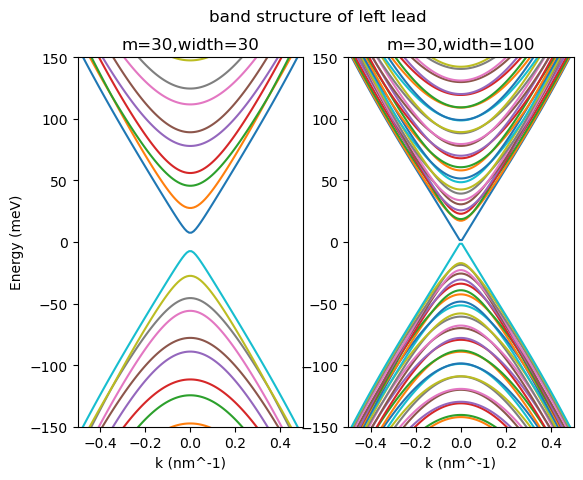

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('band structure of left lead')

ax1.set_ylabel('Energy (meV)')
ax1.set_title('m=30,width=30')
ax2.set_title('m=30,width=100')
for ax in (ax1,ax2):
    ax.set_xlabel('k (nm^-1)')
    ax.set_ylim(-150,150)
    ax.set_xlim(-0.5,0.5)

syst1=make_syst(width=30,leads_model=model_MTI()).leads[0]
syst2=make_syst(width=100,leads_model=model_MTI()).leads[0]

kwant.plotter.bands(syst1,momenta=np.linspace(-0.5, 0.5, 100), ax=ax1, params=dict(m=30));
kwant.plotter.bands(syst2,momenta=np.linspace(-0.5, 0.5, 100), ax=ax2, params=dict(m=30));

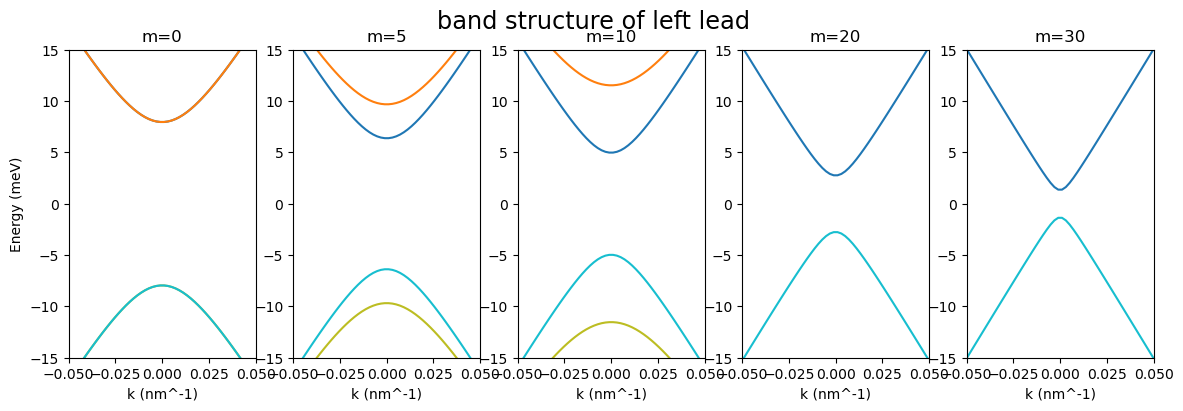

In [ ]:
syst1=make_syst(width=60,leads_model=model_MTI()).leads[0]

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize=(14, 4))
fig.suptitle('band structure of left lead', size='xx-large')

ax1.set_ylabel('Energy (meV)')
for ax in zip((ax1,ax2,ax3,ax4,ax5),(0,5,10,20,30)):
    ax[0].set_xlabel('k (nm^-1)')
    ax[0].set_ylim(-15,15)
    ax[0].set_xlim(-0.05,0.05)
    ax[0].set_title(f'm={ax[1]}')
    kwant.plotter.bands(syst1,momenta=np.linspace(-0.05, 0.05, 50), ax=ax[0], params=dict(m=ax[1]));


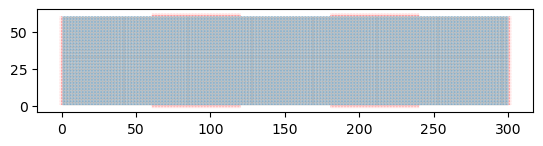

In [ ]:
syst=make_syst(width=60,length=300,leads_model=model_MTI())
kwant.plot(syst);

In [4]:
tmatrix = kwant.smatrix(syst, 3.0,params=dict(m=30))
tm=tmatrix.conductance_matrix()
np.round(tm,2)

array([[ 0.94, -0.  , -0.  , -0.  , -0.05, -0.89],
       [-0.89,  0.94, -0.  , -0.  , -0.  , -0.05],
       [-0.05, -0.82,  0.94, -0.  , -0.07, -0.  ],
       [-0.  , -0.05, -0.89,  0.94, -0.  , -0.  ],
       [-0.  , -0.  , -0.05, -0.89,  0.94, -0.  ],
       [-0.  , -0.07, -0.  , -0.05, -0.82,  0.94]])

In [9]:
def find_voltages(tmatrix,current):
    try:
        voltage = np.linalg.solve(tmatrix[1:, 1:], current[1:])
    except np.linalg.LinAlgError as err:
        if 'Singular matrix' in str(err):
            print("Hi there, singular matrix here")
            voltage = [0,0,0,0,0]
        else:
            raise
    return [0, *voltage]

def resistance_xx(tmatrix):
    current = [1, 0, 0, -1, 0, 0]
    voltage = find_voltages(tmatrix,current)
    
    def resistance(lead1, lead2):
        return voltage[lead1-1]-voltage[lead2-1]

    return resistance(2, 3)

def resistance_xy(tmatrix):
    current = [1, 0, 0, -1, 0, 0]
    voltage = find_voltages(tmatrix,current)
    
    def resistance(lead1, lead2):
        return voltage[lead1-1]-voltage[lead2-1]

    return resistance(2, 6)

def rMplot(m_list, data, ptitle='resistance vs m'):
    rxx=[]
    rxy=[]
    for i in range(data.shape[0]):
        rxx.append(resistance_xx(data[i]))
        rxy.append(resistance_xy(data[i]))

    plt.plot(m_list,rxx,'-o', label='$R_{xx}$')
    plt.plot(m_list,rxy,'-o', label='$R_{xy}$')

    plt.title(ptitle, size='xx-large')
    plt.xlabel('m')
    plt.ylabel('Resistance')
    plt.legend()


# define a function to plot the resistance vs energy
# here, "data" is a "np.array", a list (different energy) of 6*6 transimission matrices=[]
def rEplot(energies, data, ptitle='resistance vs energy'):
    rxx=[]
    rxy=[]
    for i in range(data.shape[0]):
        rxx.append(resistance_xx(data[i]))
        rxy.append(resistance_xy(data[i]))

    plt.plot(energies,rxx,'-o', label='$R_{xx}$')
    plt.plot(energies,rxy,'-o', label='$R_{xy}$')

    plt.title(ptitle, size='xx-large')
    plt.xlabel('Energy')
    plt.ylabel('Resistance')
    plt.legend()



In [ ]:
data=[]
m_range=np.linspace(-25,25,num=20)
for m_value in m_range:
    tmatrix = kwant.smatrix(syst, 9.0,params=dict(m=m_value))
    data.append(tmatrix.conductance_matrix())

# cost around 2 mins

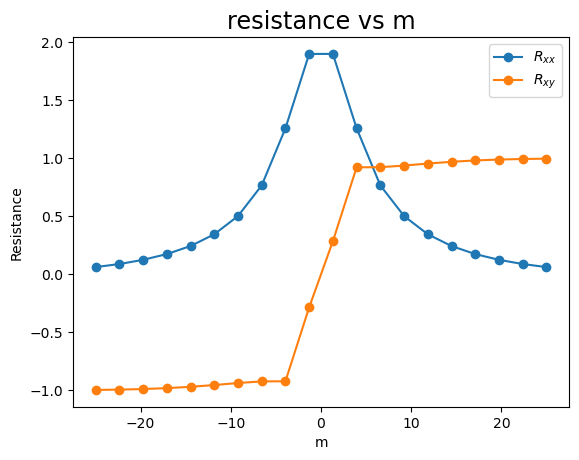

In [8]:
rMplot(m_range,np.array(data))

In [11]:
np.round(data[0],2)

array([[ 0.98, -0.96, -0.02, -0.  , -0.  , -0.  ],
       [-0.  ,  0.98, -0.91, -0.02, -0.  , -0.06],
       [-0.  , -0.  ,  0.98, -0.96, -0.02, -0.  ],
       [-0.  , -0.  , -0.  ,  0.98, -0.96, -0.02],
       [-0.02, -0.  , -0.06, -0.  ,  0.98, -0.91],
       [-0.96, -0.02, -0.  , -0.  , -0.  ,  0.98]])

In [14]:
np.round(data[3],2)

array([[ 0.95, -0.89, -0.05, -0.  , -0.  , -0.  ],
       [-0.  ,  0.95, -0.76, -0.05, -0.  , -0.14],
       [-0.  , -0.  ,  0.95, -0.89, -0.06, -0.  ],
       [-0.  , -0.  , -0.  ,  0.95, -0.89, -0.05],
       [-0.05, -0.  , -0.14, -0.  ,  0.95, -0.76],
       [-0.89, -0.06, -0.  , -0.  , -0.  ,  0.95]])

In [13]:
np.round(data[6],2)

array([[ 0.86, -0.76, -0.09, -0.01, -0.  , -0.  ],
       [-0.  ,  0.89, -0.49, -0.09, -0.  , -0.32],
       [-0.  , -0.  ,  0.89, -0.76, -0.13, -0.  ],
       [-0.01, -0.  , -0.  ,  0.86, -0.76, -0.09],
       [-0.09, -0.  , -0.32, -0.  ,  0.89, -0.49],
       [-0.76, -0.13, -0.  , -0.  , -0.  ,  0.89]])

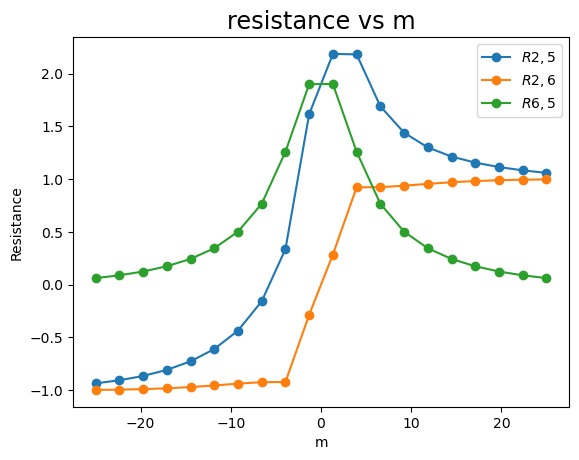

In [26]:
def rMplot_m(m_list, data, lead1=2,lead2=5, ptitle='resistance vs m'):
    current = [1, 0, 0, -1, 0, 0]
    rx=[]
    for i in range(data.shape[0]):
        voltage = find_voltages(data[i],current)
        rx.append(voltage[lead1-1]-voltage[lead2-1])

    plt.plot(m_list,rx,'-o', label=f'$R {lead1},{lead2}$')

    plt.title(ptitle, size='xx-large')
    plt.xlabel('m')
    plt.ylabel('Resistance')
    plt.legend()

rMplot_m(m_range,np.array(data),2,5)
rMplot_m(m_range,np.array(data),2,6)
rMplot_m(m_range,np.array(data),6,5)

In [20]:
syst=make_syst(width=60,length=300,leads_model=model_MTI())

In [28]:
data=[]
e_range=np.linspace(0,15,num=20)
for energy in e_range:
    tmatrix = kwant.smatrix(syst, energy,params=dict(m=20))
    data.append(tmatrix.conductance_matrix())

Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here


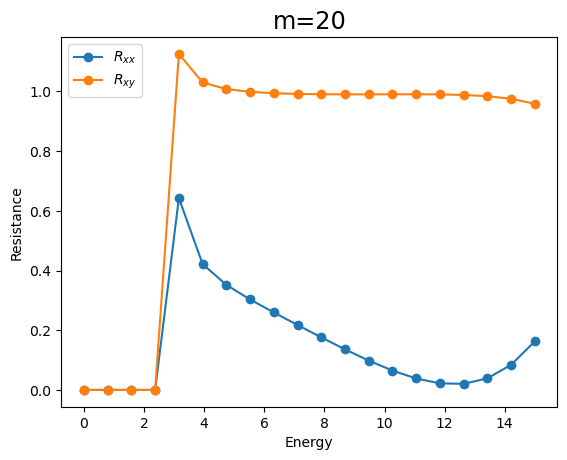

In [29]:
rEplot(e_range,np.array(data),"m=20")

In [26]:
data=[]
e_range=np.linspace(0,15,num=20)
for energy in e_range:
    tmatrix = kwant.smatrix(syst, energy,params=dict(m=40))
    data.append(tmatrix.conductance_matrix())

Hi there, singular matrix here
Hi there, singular matrix here


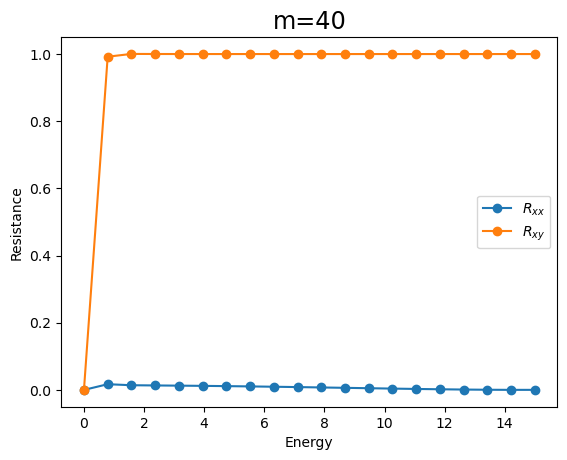

In [27]:
rEplot(e_range,np.array(data),"m=40")

somehow, the QSHE tranport signature does not show for m=0

compared to BZH model, the term Δ should be non-zero

In [30]:
data=[]
e_range=np.linspace(10,15,num=20)
for energy in e_range:
    tmatrix = kwant.smatrix(syst, energy,params=dict(m=0))
    data.append(tmatrix.conductance_matrix())

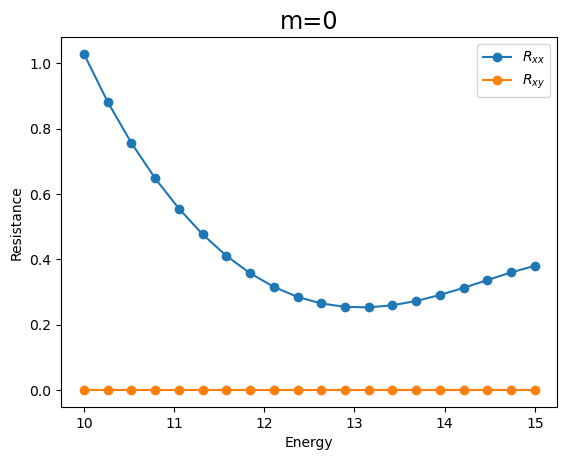

In [31]:
rEplot(e_range,np.array(data),"m=0")

In [32]:
syst=make_syst(width=100,length=500,leads_model=model_MTI())

In [33]:
data=[]
e_range=np.linspace(10,15,num=10)
for energy in e_range:
    tmatrix = kwant.smatrix(syst, energy,params=dict(m=0))
    data.append(tmatrix.conductance_matrix())

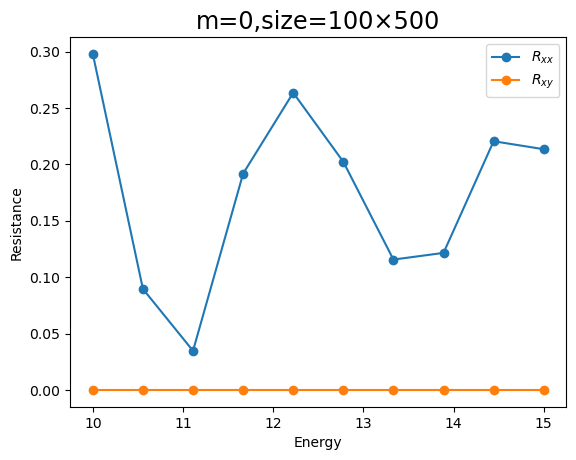

In [34]:
rEplot(e_range,np.array(data),"m=0,size=100×500")

In [44]:
np.round(data[0],2)

array([[ 1.72, -0.5 , -0.19, -0.35, -0.19, -0.5 ],
       [-0.5 ,  1.89, -0.13, -0.19, -0.08, -1.  ],
       [-0.19, -0.13,  1.89, -0.5 , -1.  , -0.08],
       [-0.35, -0.19, -0.5 ,  1.72, -0.5 , -0.19],
       [-0.19, -0.08, -1.  , -0.5 ,  1.89, -0.13],
       [-0.5 , -1.  , -0.08, -0.19, -0.13,  1.89]])

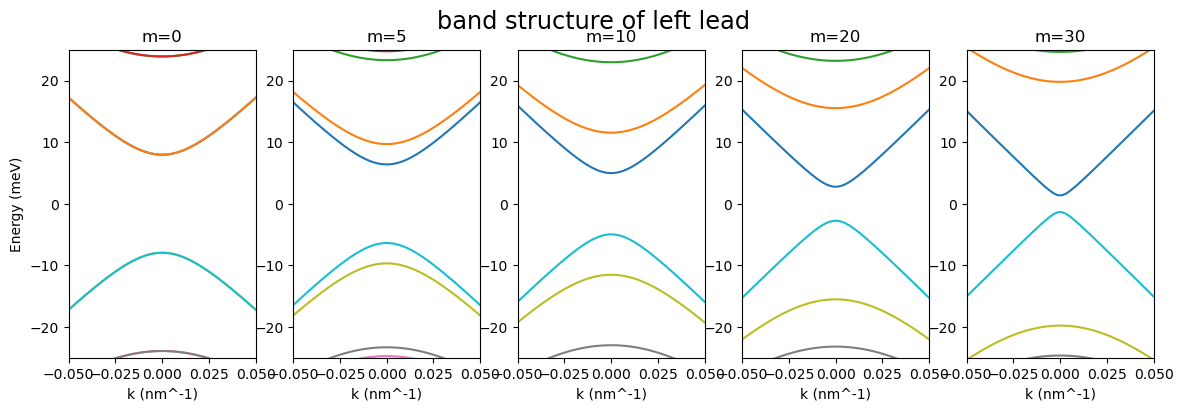

In [36]:
syst1=make_syst(width=60,leads_model=model_MTI()).leads[0]

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize=(14, 4))
fig.suptitle('band structure of left lead', size='xx-large')

ax1.set_ylabel('Energy (meV)')
for ax in zip((ax1,ax2,ax3,ax4,ax5),(0,5,10,20,30)):
    ax[0].set_xlabel('k (nm^-1)')
    ax[0].set_ylim(-25,25)
    ax[0].set_xlim(-0.05,0.05)
    ax[0].set_title(f'm={ax[1]}')
    kwant.plotter.bands(syst1,momenta=np.linspace(-0.05, 0.05, 50), ax=ax[0], params=dict(m=ax[1]));


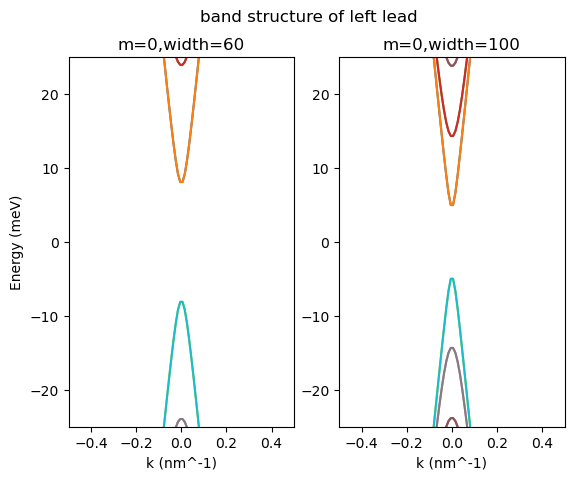

In [41]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('band structure of left lead')

ax1.set_ylabel('Energy (meV)')
ax1.set_title('m=0,width=60')
ax2.set_title('m=0,width=100')
for ax in (ax1,ax2):
    ax.set_xlabel('k (nm^-1)')
    ax.set_ylim(-25,25)
    ax.set_xlim(-0.5,0.5)

syst1=make_syst(width=60,leads_model=model_MTI()).leads[0]
syst2=make_syst(width=100,leads_model=model_MTI()).leads[0]

kwant.plotter.bands(syst1,momenta=np.linspace(-0.5, 0.5, 100), ax=ax1, params=dict(m=0));
kwant.plotter.bands(syst2,momenta=np.linspace(-0.5, 0.5, 100), ax=ax2, params=dict(m=0));

In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import tinyarray

sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

I_4= tinyarray.array(np.kron(sigma_0, sigma_0))
gamma_1 = tinyarray.array(np.kron(sigma_0, sigma_z))
gamma_2 = tinyarray.array(np.kron(sigma_z, sigma_z))
gamma_3 = tinyarray.array(np.kron(sigma_0, sigma_y))
gamma_4 = tinyarray.array(np.kron(sigma_0, sigma_x))

B=-300
g=300
D= -20
las=1

structure=kwant.lattice.square(las)
model_sym= kwant.TranslationalSymmetry(structure.vec((-1,0)),structure.vec((0,-1)))

def onsite(site,m):
    return m/2*gamma_1 - (4*B)/las**2 * gamma_2 + D * gamma_2

hopping_x = B/(las**2)*gamma_2 + 1j*g/(2*las)*gamma_3
hopping_y = B/(las**2)*gamma_2 - 1j*g/(2*las)*gamma_4

def model_MTI():
    model_1= kwant.Builder(model_sym)

    model_1[structure(0, 0)] = onsite
    model_1[kwant.builder.HoppingKind((1,0), structure)]  = hopping_x
    model_1[kwant.builder.HoppingKind((0,1), structure)]  = hopping_y

    return model_1

def model_EG():

    onsite_leads= 150 *I_4
    hopping_leads= -150 *I_4

    model_2= kwant.Builder(model_sym)
    model_2[structure(0, 0)] = onsite_leads
    model_2[structure.neighbors()]  = hopping_leads

    return model_2

def make_syst(width=50,length=100,leads_model=model_EG()):
    
    ########### create the scattering center

    def shape_center(site):
        x, y = site.pos
        return 0 < x <= length and 0 < y <= width

    syst= kwant.Builder()
    syst.fill(model_MTI(), shape_center,(1,1))

    ########### create the leads

    width_lead = length//5

    lead0= kwant.Builder(kwant.TranslationalSymmetry((-1,0)))
    lead1= kwant.Builder(kwant.TranslationalSymmetry((0,1)))
    lead2= kwant.Builder(kwant.TranslationalSymmetry((0,1)))

    def shape_lead0(site):
        x, y = site.pos
        return 0 < y <= width

    def shape_lead1(site):
        x, y = site.pos
        return width_lead < x <= 2*width_lead

    def shape_lead2(site):
        x, y = site.pos
        return 3*width_lead < x <= 4*width_lead

    lead0.fill(leads_model, shape_lead0, (0, 1))
    lead1.fill(leads_model, shape_lead1, (width_lead+1, 0))
    lead2.fill(leads_model, shape_lead2, (3*width_lead+1, 0))

    ########### create the six-terminal device
    for lead in [lead0,lead1,lead2, lead0.reversed(),lead2.reversed(),lead1.reversed()]:
        syst.attach_lead(lead)

    return syst.finalized()


c:\Users\ted12\miniforge3\lib\site-packages\kwant\solvers\default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


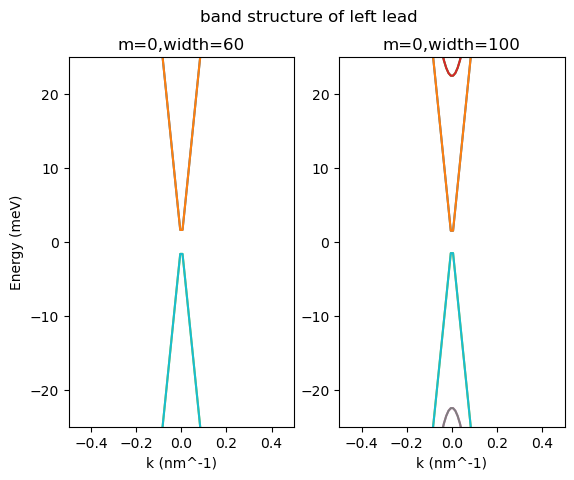

In [30]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('band structure of left lead')

ax1.set_ylabel('Energy (meV)')
ax1.set_title('m=0,width=60')
ax2.set_title('m=0,width=100')
for ax in (ax1,ax2):
    ax.set_xlabel('k (nm^-1)')
    ax.set_ylim(-25,25)
    ax.set_xlim(-0.5,0.5)

syst1=make_syst(width=60,leads_model=model_MTI()).leads[0]
syst2=make_syst(width=100,leads_model=model_MTI()).leads[0]

kwant.plotter.bands(syst1,momenta=np.linspace(-0.5, 0.5, 100), ax=ax1, params=dict(m=0));
kwant.plotter.bands(syst2,momenta=np.linspace(-0.5, 0.5, 100), ax=ax2, params=dict(m=0));

In [41]:
syst1=make_syst(width=60,leads_model=model_MTI()).leads[0]


In [42]:
bands = kwant.physics.Bands(syst1, params=dict(m=0))
momenta=np.linspace(-0.05, 0.05, 200)

es=[]
evs=[]
for k in momenta:
    tem_a,tem_b= bands(k=k,return_eigenvectors = True) 
    es.append(tem_a)
    evs.append(tem_b)

In [3]:
zcolors=[]
for k in range(len(momenta)):
    tem_1=[]
    for i in range(np.array(es).shape[1]):
            swf=np.reshape(np.abs(evs[k][:,i])**2,(-1,2)).sum(1)
            tem_c=swf.reshape(2,-1).sum(1)
            tem_1.append(tem_c[0]-tem_c[1])
    zcolors.append(tem_1)

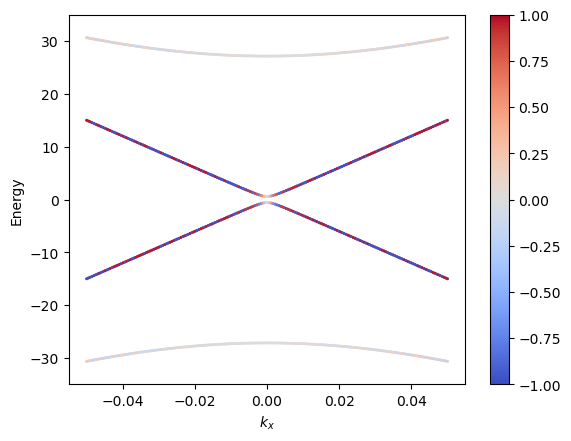

In [44]:
for i in range(np.array(es).shape[1]):
    plt.scatter(momenta,np.array(es)[:,i],s=1,c=np.array(zcolors)[:,i],cmap="coolwarm",vmin=-1.,vmax=1.)
plt.ylim(-35,35)
plt.xlabel('$k_x$')
plt.ylabel('Energy')
plt.colorbar();

In [ ]:
syst=make_syst(width=60,length=300,leads_model=model_MTI())

In [36]:
data=[]
e_range=np.linspace(10,15,num=20)
for energy in e_range:
    tmatrix = kwant.smatrix(syst, energy,params=dict(m=0))
    data.append(tmatrix.conductance_matrix())

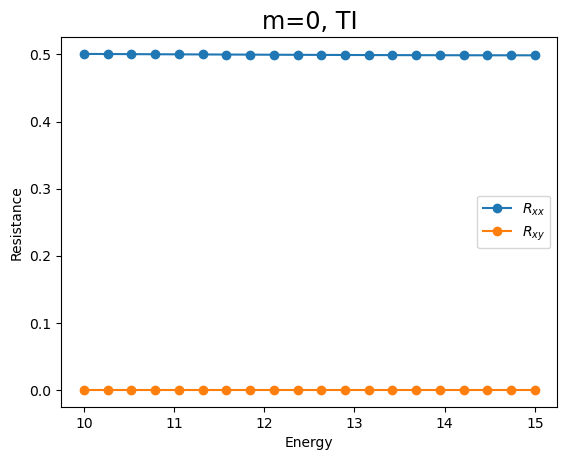

In [39]:
rEplot(e_range,np.array(data),"m=0, TI")

In [ ]:
syst=make_syst(width=60,leads_model=model_MTI()).leads[0]

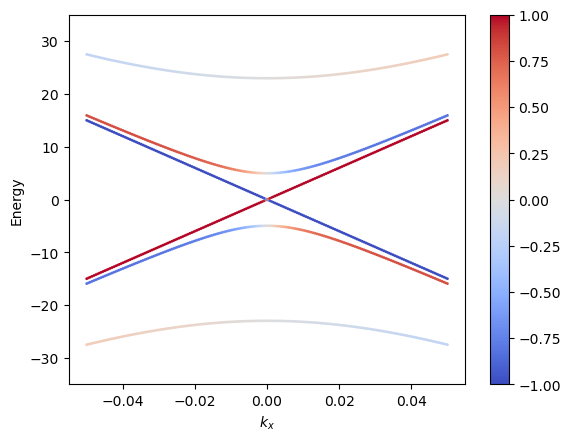

In [5]:
bands = kwant.physics.Bands(syst, params=dict(m=30))
momenta=np.linspace(-0.05, 0.05, 200)

es=[]
evs=[]
for k in momenta:
    tem_a,tem_b= bands(k=k,return_eigenvectors = True) 
    es.append(tem_a)
    evs.append(tem_b)

for i in range(np.array(es).shape[1]):
    plt.scatter(momenta,np.array(es)[:,i],s=1,c=np.array(zcolors)[:,i],cmap="coolwarm",vmin=-1.,vmax=1.)
plt.ylim(-35,35)
plt.xlabel('$k_x$')
plt.ylabel('Energy')
plt.colorbar();

In [6]:
syst_A=make_syst(width=60,length=300,leads_model=model_MTI())

In [11]:
data=[]
e_range=np.linspace(0,10,num=20)
for energy in e_range:
    tmatrix = kwant.smatrix(syst_A, energy,params=dict(m=30))
    data.append(tmatrix.conductance_matrix())

Hi there, singular matrix here
Hi there, singular matrix here


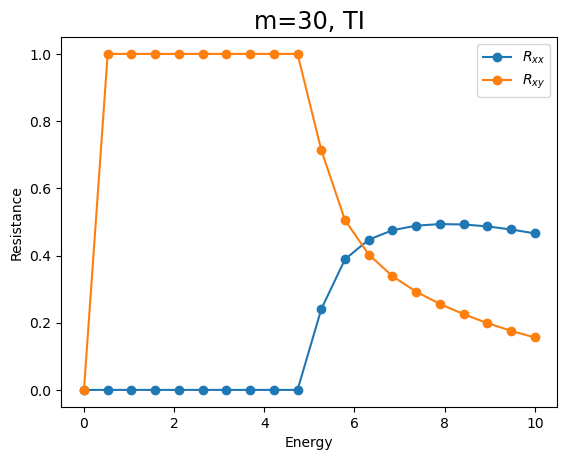

In [13]:
rEplot(e_range,np.array(data),"m=30, TI")

In [14]:
data=[]
e_range=np.linspace(10,20,num=20)
for energy in e_range:
    tmatrix = kwant.smatrix(syst_A, energy,params=dict(m=30))
    data.append(tmatrix.conductance_matrix())

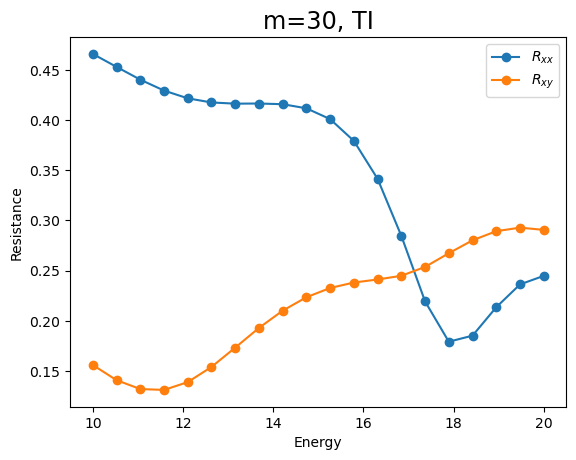

In [15]:
rEplot(e_range,np.array(data),"m=30, TI")

#### distribution of wavefuncion

In [ ]:
syst1=make_syst(width=60,leads_model=model_MTI()).leads[0]


In [4]:
bands = kwant.physics.Bands(syst1, params=dict(m=20))
momenta=np.linspace(-0.05, 0.05, 200)

es=[]
evs=[]
for k in momenta:
    tem_a,tem_b= bands(k=k,return_eigenvectors = True) 
    es.append(tem_a)
    evs.append(tem_b)

In [ ]:
[np.array(es).shape, np.array(evs).shape]

# 200 k points (momenta) are taken, that is 200 states
# there are 60 sites, and each site has a freedom of 4. Therefore, the freedom (dimension of matrix, number of bands) is 240 for each state

[(200, 240), (200, 240, 240)]

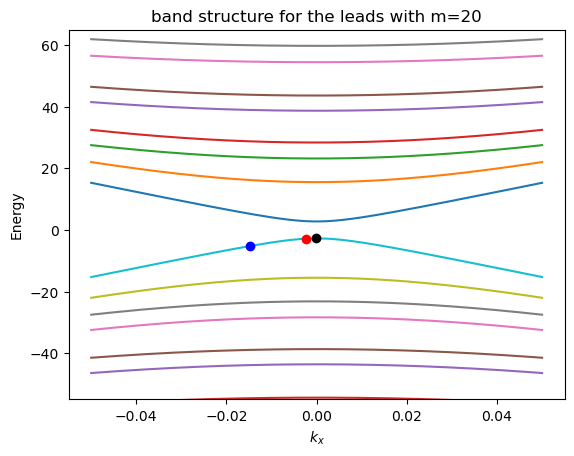

In [24]:
# the 100th, 96th and 70th states (k values) are chosen, the 120th energy level (band) is chosen
plt.plot(momenta,es);
plt.plot(momenta[99], es[99][119], 'ko')
plt.plot(momenta[95], es[95][119], 'ro')
plt.plot(momenta[70], es[70][119], 'bo')
plt.ylim(-55,65)
plt.xlabel('$k_x$')
plt.ylabel('Energy')
plt.title('band structure for the leads with m=20');

Text(0, 0.5, 'possibility of the wavefunction')

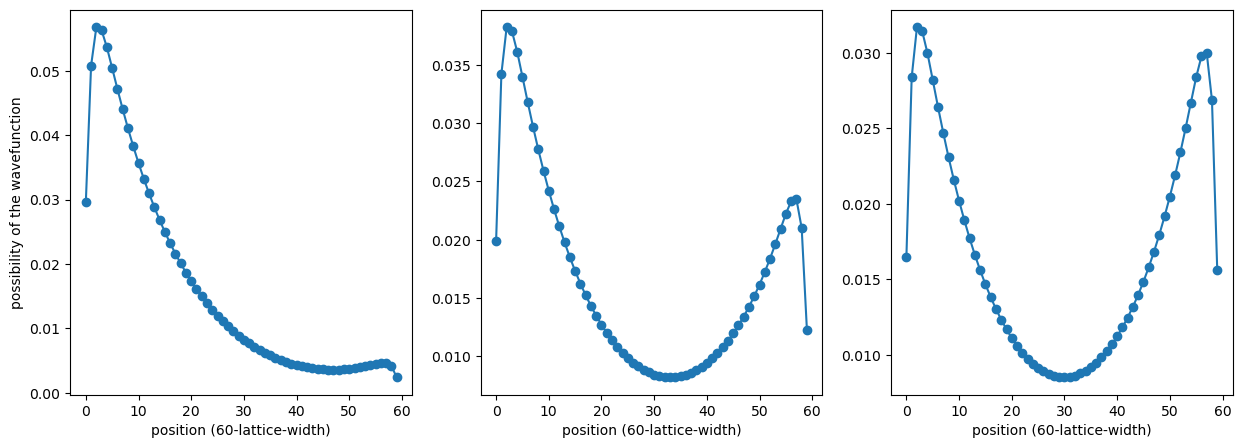

In [27]:
swf1=np.abs(evs[70][:,119])**2
swf2=np.abs(evs[95][:,119])**2
swf3=np.abs(evs[99][:,119])**2
fig,(ax1,ax2,ax3)=plt.subplots(1,3, figsize=(15,5))
ax1.plot(range(60),swf1.reshape((-1,4)).sum(1),'-o')
ax2.plot(range(60),swf2.reshape((-1,4)).sum(1),'-o')
ax3.plot(range(60),swf3.reshape((-1,4)).sum(1),'-o')

for ax in (ax1,ax2,ax3):
    ax.set_xlabel('position (60-lattice-width)')
ax1.set_ylabel('possibility of the wavefunction')

# 1. take the absolute value of the wavefunction and make the square
# 2. split the "array1" into parts (each parts has 4 values, i.e. the inner freedom of 4 at the same site is grouped) by using np.reshape(array1,(-1,4)), check the example-1 below
# 3. sum the parts splitted, i.e. sum the inner freedom of 4

In [7]:
zcolors=[]
for k in range(len(momenta)):
    tem_1=[]
    for i in range(np.array(es).shape[1]):
            swf=np.reshape(np.abs(evs[k][:,i])**2,(-1,2)).sum(1)
            tem_c=swf.reshape(2,-1).sum(1)
            tem_1.append(tem_c[0]-tem_c[1])
    zcolors.append(tem_1)

# 1. take the absolute value of the i-th wavefunction and make the square
# 2. split the "array1" into parts (each parts has 4 values, i.e. the inner freedom of 4 at the same site is grouped) by using np.reshape(array1,(-1,4)), check the example-1 below
# 3. sum the parts splitted, i.e. sum the inner freedom of 4
# 4. in a similliar way, split the "array2" into two parts (two half part of sites) and sum each part by using "array2.reshape(2,-1).sum(1)"
# 5. use the one sum of parts substract the other one.

np.array(zcolors).shape

(200, 240)

In [15]:
# example-1
a = np.arange(16)
a, a.reshape(-1,4), np.reshape(a,(-1,4)).sum(1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]]),
 array([ 6, 22, 38, 54]))

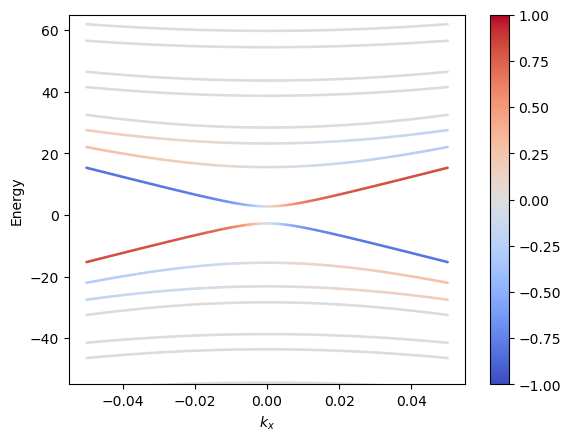

In [18]:
for i in range(np.array(es).shape[1]):
    plt.scatter(momenta,np.array(es)[:,i],s=1,c=np.array(zcolors)[:,i],cmap="coolwarm",vmin=-1.,vmax=1.)
plt.ylim(-55,65)
plt.xlabel('$k_x$')
plt.ylabel('Energy')
plt.colorbar();

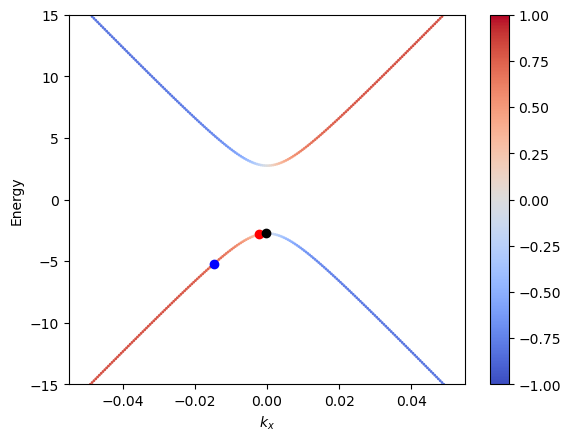

In [26]:
for i in range(np.array(es).shape[1]):
    plt.scatter(momenta,np.array(es)[:,i],s=1,c=np.array(zcolors)[:,i],cmap="coolwarm",vmin=-1.,vmax=1.)
plt.plot(momenta[70], es[70][119], 'bo')
plt.plot(momenta[95], es[95][119], 'ro')
plt.plot(momenta[99], es[99][119], 'ko')
plt.ylim(-15,15)
plt.xlabel('$k_x$')
plt.ylabel('Energy')
plt.colorbar();

## old code

In [ ]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import tinyarray

sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

I_4= tinyarray.array(np.kron(sigma_0, sigma_0))
gamma_1 = tinyarray.array(np.kron(sigma_0, sigma_z))
gamma_2 = tinyarray.array(np.kron(sigma_z, sigma_z))
gamma_3 = tinyarray.array(np.kron(sigma_0, sigma_y))
gamma_4 = tinyarray.array(np.kron(sigma_0, sigma_x))

B=-300
g=300
las=1
m=1
width=30

def make_syst(width=50,length=100):
    
    onsite =  m/2*gamma_1 - (4*B)/las**2 * gamma_2
    hopping_x = B/(las**2)*gamma_2 + 1j*g/(2*las)*gamma_3
    hopping_y = B/(las**2)*gamma_2 - 1j*g/(2*las)*gamma_4

    def model():
        structure=kwant.lattice.square(las)
        model_sym= kwant.TranslationalSymmetry(structure.vec((-1,0)),structure.vec((0,-1)))
        model_1= kwant.Builder(model_sym)

        model_1[structure(0, 0)] = onsite
        model_1[kwant.builder.HoppingKind((1,0), structure)]  = hopping_x
        model_1[kwant.builder.HoppingKind((0,1), structure)]  = hopping_y

        return model_1

    ########### create the scattering center

    def shape_center(site):
        x, y = site.pos
        return 0 < x <= length and 0 < y <= width

    syst= kwant.Builder()
    syst.fill(model(), shape_center,(1,1))

    ########### create the leads

    def electronGas_model():
        structure=kwant.lattice.square(las)

        onsite_leads= 150 *I_4
        hopping_leads= -150 *I_4

        model_sym= kwant.TranslationalSymmetry(structure.vec((-1,0)),structure.vec((0,-1)))
        model_1= kwant.Builder(model_sym)

        model_1[structure(0, 0)] = onsite_leads
        model_1[structure.neighbors()]  = hopping_leads

        return model_1

    width_lead = length//5 

    lead0= kwant.Builder(kwant.TranslationalSymmetry((-1,0)))
    lead1= kwant.Builder(kwant.TranslationalSymmetry((0,1)))
    lead2= kwant.Builder(kwant.TranslationalSymmetry((0,1)))

    def shape_lead0(site):
        x, y = site.pos
        return 0 < y <= width

    def shape_lead1(site):
        x, y = site.pos
        return width_lead < x <= 2*width_lead

    def shape_lead2(site):
        x, y = site.pos
        return 3*width_lead < x <= 4*width_lead

    lead0.fill(electronGas_model(), shape_lead0, (0, 1))
    lead1.fill(electronGas_model(), shape_lead1, (width_lead+1, 0))
    lead2.fill(electronGas_model(), shape_lead2, (3*width_lead+1, 0))

    ########### create the six-terminal device
    for lead in [lead0,lead1,lead2, lead0.reversed(),lead2.reversed(),lead1.reversed()]:
        syst.attach_lead(lead)


    return syst.finalized()  


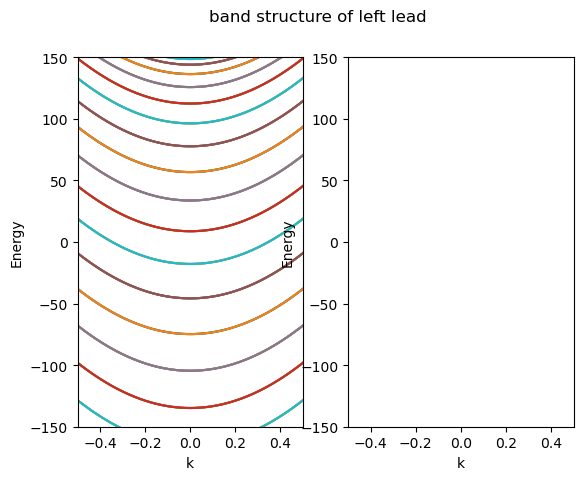

In [58]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('band structure of left lead')

for ax in (ax1,ax2):
    ax.set_xlabel('k')
    ax.set_ylabel('Energy')
    ax.set_ylim(-150,150)
    ax.set_xlim(-0.5,0.5)

syst1=make_syst(30).leads[0]

kwant.plotter.bands(syst1,momenta=np.linspace(-0.5, 0.5, 100), ax=ax1);

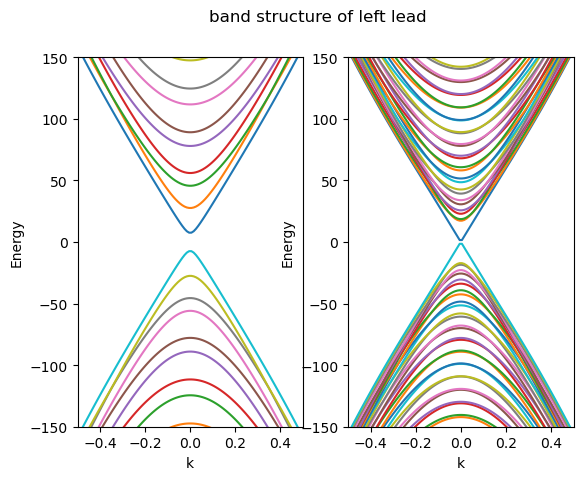

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('band structure of left lead')

for ax in (ax1,ax2):
    ax.set_xlabel('k')
    ax.set_ylabel('Energy')
    ax.set_ylim(-150,150)
    ax.set_xlim(-0.5,0.5)

syst1=make_syst(30).leads[0]
syst2=make_syst(100).leads[0]

kwant.plotter.bands(syst1,momenta=np.linspace(-0.5, 0.5, 100), ax=ax1);
kwant.plotter.bands(syst2,momenta=np.linspace(-0.5, 0.5, 100), ax=ax2);

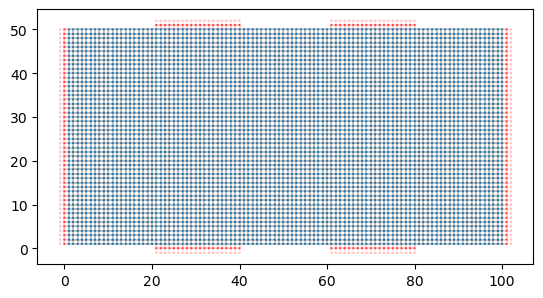

In [16]:
kwant.plot(make_syst());

In [12]:
tmatrix = kwant.smatrix(make_syst(), 3.0)
tmatrix.conductance_matrix()

array([[ 0.99190495, -0.        , -0.        , -0.99190495, -0.        ,
        -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ],
       [-0.99190495, -0.        , -0.        ,  0.99190495, -0.        ,
        -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ]])

In [55]:
def find_voltages(tmatrix,current):  #注意：该函数返回的V是所有V的矩阵        #tmatrix是传输矩阵，在此处还未定义，current是电流分布[1, 0, 0, -1, 0, 0] 表示电流从端口1流入，端口4流出。
    try:                                                            #np.linalg.solve()函数用于求解线性方程组，返回值是一个数组，数组中的每个元素是一个未知数的解   
        voltage = np.linalg.solve(tmatrix[1:, 1:], current[1:])     #tmatrix[1:, 1:]表示tmatrix的第一行和第一列被删去 current[1:]表示current的第一个元素被删去  
    except np.linalg.LinAlgError as err:                            #当检测到奇异矩阵时，即该函数无解，避免程序崩溃，强制返回零电压
        if 'Singular matrix' in str(err):
            print("Hi there, singular matrix here")
            voltage = [0,0,0,0,0]
        else:
            raise
    return [0, *voltage]    ##在电压列表前添加一个 0，表示第一个端口的电压为0（参考接地）。
  
def resistance_xx(tmatrix):
    current = [1, 0, 0, -1, 0, 0]
    voltage = find_voltages(tmatrix,current)
  
    def resistance(lead1, lead2): 
        return voltage[lead1-1]-voltage[lead2-1] ##默认电流为1 ###将端口的序号索引转化为数组索引
  
    return resistance(2, 3) ##电流从端口2流入，端口3流出，电压差为V2-V3
  
##
  
def resistance_xy(tmatrix):
    current = [1, 0, 0, -1, 0, 0]
    voltage = find_voltages(tmatrix,current)
  
    def resistance(lead1, lead2):
        return voltage[lead1-1]-voltage[lead2-1]
  
    return resistance(2, 6)  

In [56]:
tmatrix = kwant.smatrix(make_syst(60,300), 3.0)

In [57]:
(resistance_xy(tmatrix.conductance_matrix()),
resistance_xx(tmatrix.conductance_matrix()))

(0.7182077422630755, 146.14502203014945)

### band structure

In [ ]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import tinyarray

sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

gamma_1 = tinyarray.array(np.kron(sigma_0, sigma_z))   
gamma_2 = tinyarray.array(np.kron(sigma_z, sigma_z))  
gamma_3 = tinyarray.array(np.kron(sigma_0, sigma_y))
gamma_4 = tinyarray.array(np.kron(sigma_0, sigma_x))

B=-300
g=300
las=1
m=30
width=30

def make_syst(width=30):
    onsite =  m/2*gamma_1 - (4*B)/las**2 * gamma_2
    hopping_x = B/(las**2)*gamma_2 + 1j*g/(2*las)*gamma_3
    hopping_y = B/(las**2)*gamma_2 - 1j*g/(2*las)*gamma_4

    ########### crystal structure
    structure=kwant.lattice.square(las)

    ########### create a translational invariant system
    syst = kwant.Builder(kwant.TranslationalSymmetry((-las,0)))

    def shape_y(pos):
        x, y = pos
        return 0 < y <= width

    syst[structure.shape(shape_y,(0,1))] = onsite

    syst[kwant.builder.HoppingKind((1,0), structure)]  = hopping_x
    syst[kwant.builder.HoppingKind((0,1), structure)]  = hopping_y

    return syst.finalized()  


c:\Users\ted12\miniforge3\lib\site-packages\kwant\solvers\default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


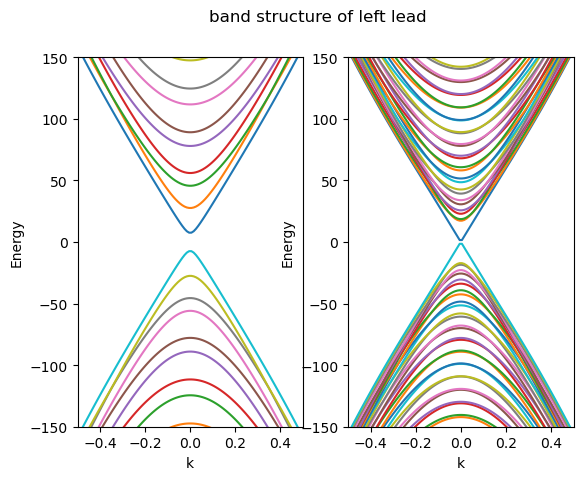

In [6]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('band structure of left lead')

for ax in (ax1,ax2):
    ax.set_xlabel('k')
    ax.set_ylabel('Energy')
    ax.set_ylim(-150,150)
    ax.set_xlim(-0.5,0.5)

syst1=make_syst()
syst2=make_syst(100)

kwant.plotter.bands(syst1,momenta=np.linspace(-0.5, 0.5, 100), ax=ax1);
kwant.plotter.bands(syst2,momenta=np.linspace(-0.5, 0.5, 100), ax=ax2);

### clear code

In [ ]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import tinyarray

sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

gamma_1 = tinyarray.array(np.kron(sigma_0, sigma_z))   
gamma_2 = tinyarray.array(np.kron(sigma_z, sigma_z))  
gamma_3 = tinyarray.array(np.kron(sigma_0, sigma_y))
gamma_4 = tinyarray.array(np.kron(sigma_0, sigma_x))

B=-300
g=300
las=1
m=30
width=30

onsite =  m/2*gamma_1 - (4*B)/las**2 * gamma_2
hopping_x = B/(las**2)*gamma_2 + 1j*g/(2*las)*gamma_3
hopping_y = B/(las**2)*gamma_2 - 1j*g/(2*las)*gamma_4

########### crystal structure
structure=kwant.lattice.square(las)

########### create a translational invariant system
syst = kwant.Builder(kwant.TranslationalSymmetry((-las,0)))

def shape_y(pos):
    x, y = pos
    return 0 < y <= width

syst[structure.shape(shape_y,(0,1))] = onsite

syst[kwant.builder.HoppingKind((1,0), structure)]  = hopping_x
syst[kwant.builder.HoppingKind((0,1), structure)]  = hopping_y

syst1 = syst.finalized()  



c:\Users\ted12\miniforge3\lib\site-packages\kwant\solvers\default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


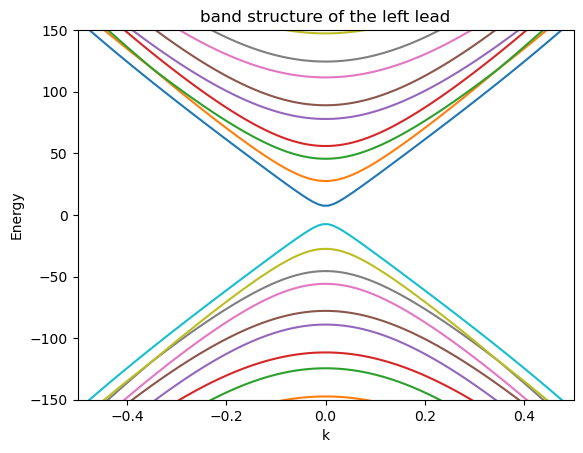

In [2]:
fig, ax4 = plt.subplots()
ax4.set_title('band structure of the left lead')
ax4.set_xlabel('k')
ax4.set_ylabel('Energy')
ax4.set_ylim(-150,150)
ax4.set_xlim(-0.5,0.5)

kwant.plotter.bands(syst1,momenta=np.linspace(-0.5, 0.5, 100), ax=ax4);